# Monitoring of model
 Evaluate model on data and obtain metrics of performance

## Load libraries

In [1]:
pip install tabgan==1.3.3

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install lightgbm

In [3]:
pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install scipy==1.11.4

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install --upgrade pandas "dask[complete]"

Note: you may need to restart the kernel to use updated packages.


In [6]:
## librerias requeridas
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import re
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from scikitplot.metrics import plot_roc
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_lift_curve
from scikitplot.helpers import binary_ks_curve 
from scikitplot.metrics import plot_ks_statistic
from scikitplot.helpers import cumulative_gain_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from datetime import datetime, timedelta

import pyarrow as pa
import pyarrow.parquet as pq

In [7]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.memory_usage', True)

## Load model and data to evaluate

Load variables names from file

In [8]:
import os
os.getcwd()

'/home/ec2-user/SageMaker/viamericas-dev/Analytics/5.Fraud'

In [9]:
import os
import joblib
# load model
#modelo = joblib.load("ModeloV2TodosMenosVariables.pkl") 
#variables = open('./ModeloV2TodosMenosVariables.txt','r')
modelo = joblib.load("ModeloFinal2.pkl") 
variables = open('./ModeloFinal2.txt','r')

In [10]:
modelo

LGBMClassifier(colsample_bytree=0.84, importance_type='gini',
               learning_rate=0.07, max_depth=20, min_child_weight=0.0026,
               n_estimators=520, num_leaves=30, objective='binary',
               scale_pos_weight=0.003, subsample=1)

## Veo si puedo sacar los nombres directo del modelo q cargue
## Veo como cargar el punto de corte

In [11]:
variables = open('./ModeloFinal2.txt','r')
var_input = variables.read()

In [12]:
var_input = ['01_branch_working_days', 'branch_minutes_since_last_transaction',
    'branch_trans_3m', 'branch_has_fraud', 
    'branch_trans_40min', 'branch_trans_10min', 'cash_pick_up_40min', 
    'location_nro_fraud', 'sender_trans_3m', 
    'sender_nro_fraud','01_isMexico', 
    '01_sender_branch_state', '01_var_range_hist',
    '01_branch_fraud', '01_location_fraud', '01_sender_fraud', 
    '01_isCashPick', '01_isBankDep', 
    'sender_days_to_last_transaction_more7m', 
    '01_receiver_transaction_count', '01_sender_sending_days',
    '01_branch_working_days', '01_net_amount_receiver', 
    '01_sender_minutes_since_last_transaction_2days', 
    '01_sender_days_to_last_transaction_365', 
    '01_sender_days_to_last_transaction_7m', '01_hour_receiver']

In [13]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
dfTrain = pd.read_parquet(f"s3://{s3_url}/Train/Train.parquet")
tgTrain = dfTrain['target']

dfVal = pd.read_parquet(f"s3://{s3_url}/Validation/Validation.parquet")
tgVal = dfVal['target']

#Uni test y Val
#X = pd.concat([dfTrain[var_input], dfVal[var_input]], ignore_index=True) 
X = pd.concat([dfTrain, dfVal], ignore_index=True) 
Y = pd.DataFrame(pd.concat([dfTrain['target'], dfVal['target']], ignore_index=True)) 

dias_target = ['day_name_receiver_0', 'day_name_receiver_1',
       'day_name_receiver_2', 'day_name_receiver_3',
       'day_name_receiver_4', 'day_name_receiver_5',
       'day_name_receiver_6','target']

testeo =  pd.concat([X, Y], axis=1)
Y_target = pd.DataFrame(pd.concat([dfTrain[dias_target], dfVal[dias_target]], ignore_index=True)) 

In [14]:
# Uso esto para sacar el punto de corte. Cuando lo pueda guardar esta celda se va
# Prediciendo la variable objetivo para el conjunto de datos de prueba 'X_TESTEO' utilizando el clasificador LightGBM
testeo_data_pred_rf = modelo.predict(testeo[var_input])

# Prediciendo las probabilidades de clase para cada observación en 'X_TESTEO' utilizando el clasificador LightGBM
probab_rf = modelo.predict_proba(testeo[var_input])

# Eliminando la primera columna (se asume que son las probabilidades de la clase negativa) de las probabilidades predichas
# Se asume que la segunda columna contiene las probabilidades para la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)

# Creando una copia del DataFrame 'Y_c' para preservar los datos originales
Y_c = Y_target.copy()

# Agregando una nueva columna 'preds_rf' al DataFrame copiado con las predicciones del clasificador LightGBM
Y_c['preds_rf'] = testeo_data_pred_rf

# Agregando una nueva columna 'score_rf' al DataFrame copiado con las probabilidades de la clase positiva
Y_c['score_rf'] = score_rf

#Calculo el primer percentil para sacar el punto de corte
percentiles = pd.qcut(Y_c['score_rf'], q=1000, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')

#saco el punto de corte del primer centil para aplicarlo al test
corte_01 = Y_c.score_rf[Y_c['FRAUD_DECILE']==1].min()
corte_02 = Y_c.score_rf[Y_c['FRAUD_DECILE']==2].min()
corte_03 = Y_c.score_rf[Y_c['FRAUD_DECILE']==3].min()
corte_04 = Y_c.score_rf[Y_c['FRAUD_DECILE']==4].min()
corte = Y_c.score_rf[Y_c['FRAUD_DECILE']==10].min()

In [15]:
corte

1.8209193658175857e-08

In [16]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
tes = pd.read_parquet(f"s3://{s3_url}/Test/Test.parquet")

testeo = pd.concat([X, tes], axis = 0, ignore_index=True)
Y_target = pd.DataFrame(pd.concat([Y_target, tes[dias_target]], ignore_index=True)) 

## Apply model

In [17]:
def limpiar_nombres_columnas(dataframe):
    """
    Limpia y estandariza los nombres de las columnas en un DataFrame.

    Parameters:
    - dataframe: DataFrame de pandas.

    Returns:
    - DataFrame con nombres de columnas limpios.
    """
    dataframe = dataframe.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    return dataframe

testeo = limpiar_nombres_columnas(testeo)

convert_dict = {'branch_minutes_since_last_transaction': float
                }
 
testeo = testeo.astype(convert_dict)

In [18]:
testeo['target'].value_counts(dropna=False)

target
False    26478152
True          759
Name: count, dtype: int64

In [19]:
Y_target.shape

(26478911, 8)

In [20]:
# Prediciendo la variable objetivo para el conjunto de datos de prueba 'X_TESTEO' utilizando el clasificador LightGBM
testeo_data_pred_rf = modelo.predict(testeo[var_input])

# Prediciendo las probabilidades de clase para cada observación en 'X_TESTEO' utilizando el clasificador LightGBM
probab_rf = modelo.predict_proba(testeo[var_input])

# Eliminando la primera columna (se asume que son las probabilidades de la clase negativa) de las probabilidades predichas
# Se asume que la segunda columna contiene las probabilidades para la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)


In [21]:
# Creando una copia del DataFrame 'Y_TESTEO' para preservar los datos originales
Y_c = Y_target.copy()

# Agregando una nueva columna 'preds_rf' al DataFrame copiado con las predicciones del clasificador LightGBM
Y_c['preds_rf'] = testeo_data_pred_rf

# Agregando una nueva columna 'score_rf' al DataFrame copiado con las probabilidades de la clase positiva
Y_c['score_rf'] = score_rf

In [22]:
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['preds_rf']))

,0,1
0,26478150,2
1,238,521


In [23]:
Y_c['pred_corte'] = Y_c['score_rf']>corte
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['pred_corte']))

,0,1
0,26212650,265502
1,19,740


<Axes: xlabel='score_rf', ylabel='Count'>

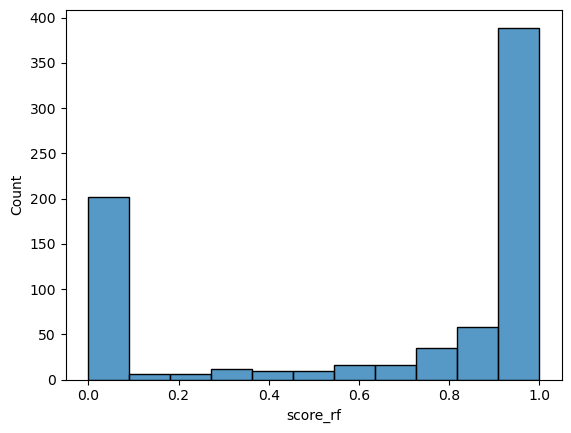

In [24]:
import seaborn as sns
sns.histplot(data = Y_c[Y_c['target'] == True], x='score_rf')

In [25]:
# Dividir las predicciones en deciles y calcular la captura del 30% en el conjunto de entrenamiento
percentiles = pd.qcut(Y_c['score_rf'], q=100, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')
print('FRAUD CAPTURA 30%:')
print(sum(Y_c[Y_c['FRAUD_DECILE'] < 4]['target']) / sum(Y_c['target']))

FRAUD CAPTURA 30%:
0.9855072463768116


In [26]:
DECILES = pd.crosstab(Y_c['FRAUD_DECILE'], Y_c['target'])
DECILES

target,False,True
FRAUD_DECILE,,
1,264050,740
2,264786,3
3,264784,5
4,264789,0
5,264786,3
...,...,...
96,264789,0
97,264789,0
98,264789,0


In [27]:
Y_c[['score_rf','FRAUD_DECILE']].groupby(['FRAUD_DECILE']).agg({'score_rf': [ 'min', 'max']}) 

score_rf              
                       min           max
FRAUD_DECILE                            
1             1.839082e-08  1.000000e+00
2             5.403308e-09  1.839074e-08
3             2.666001e-09  5.403278e-09
4             1.621040e-09  2.665988e-09
5             1.101900e-09  1.621040e-09
...                    ...           ...
96            5.155830e-13  6.190597e-13
97            4.117077e-13  5.155827e-13
98            3.053601e-13  4.117077e-13
99            1.904112e-13  3.053591e-13
100           1.787882e-15  1.904111e-13

[100 rows x 2 columns]

In [28]:
deciles_semana = Y_c[['day_name_receiver_0', 'day_name_receiver_1',
                   'day_name_receiver_2', 'day_name_receiver_3',
                   'day_name_receiver_4', 'day_name_receiver_5',
                   'day_name_receiver_6',
                 'FRAUD_DECILE']].groupby(['FRAUD_DECILE']).sum()

deciles_semana.head(10)

,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6
FRAUD_DECILE,,,,,,,
1,38005,34219,32785,32573,41586,45623,39999
2,37396,32427,30362,30538,43420,48633,42013
3,37612,31779,29561,29979,44310,49193,42355
4,37333,31679,28700,29571,44449,49781,43276
5,37114,31160,28410,28903,45145,50380,43677
6,36908,30863,28249,28865,45383,50693,43828
7,37006,30421,27935,29281,45435,50621,44090
8,37293,30633,28020,28687,45323,51045,43788
9,37560,30289,27529,28623,45653,50771,44364


In [29]:
#PERC = pd.crosstab(Y_c.FRAUD_DECILE[testeo['mes']>8], Y_c.target[testeo['mes']>8])
#PERC.to_csv ('./percentiles.csv')

## Analizo distintos puntos de corte

In [30]:
testeo['date_receiver'].dt.month
testeo['year'] = testeo['date_receiver'].dt.year
Y_c['fraud_classification'] = testeo['fraud_classification']
Y_c['targetF'] = (testeo['fraud_classification']=='Real')

In [31]:
#Veo cuantos falsos positivos tengo con el punto de corte
Y_c['pred_corte_01'] = Y_c['score_rf']>corte_01
tes_corte_01 = testeo[Y_c['pred_corte_01']==True]
Y_c_corte_01 = Y_c[Y_c['pred_corte_01']==True]

pd.crosstab(tes_corte_01['mes'], Y_c_corte_01['targetF'])

targetF,False,True
mes,,
1,1624,62
2,1866,34
3,2178,22
4,2080,61
5,2100,43
6,2101,67
7,2157,30
8,2263,36
9,2446,26


In [32]:
#Veo cuantos falsos positivos tengo con el punto de corte
Y_c['pred_corte_02'] = Y_c['score_rf']>corte_02
tes_corte_02 = testeo[Y_c['pred_corte_02']==True]
Y_c_corte_02 = Y_c[Y_c['pred_corte_02']==True]

pd.crosstab(tes_corte_02['mes'], Y_c_corte_02['targetF'])

targetF,False,True
mes,,
1,3308,63
2,3870,34
3,4447,22
4,4240,61
5,4249,44
6,4140,69
7,4377,30
8,4458,37
9,4980,32


In [33]:
#Veo cuantos falsos positivos tengo con el punto de corte
Y_c['pred_corte_03'] = Y_c['score_rf']>corte_03
tes_corte_03 = testeo[Y_c['pred_corte_03']==True]
Y_c_corte_03 = Y_c[Y_c['pred_corte_03']==True]

pd.crosstab(tes_corte_03['mes'], Y_c_corte_03['targetF'])

targetF,False,True
mes,,
1,5135,64
2,5824,34
3,6631,22
4,6331,61
5,6370,44
6,6246,69
7,6690,30
8,6586,37
9,7432,34


In [34]:
#Veo cuantos falsos positivos tengo con el punto de corte
Y_c['pred_corte_04'] = Y_c['score_rf']>corte_04
tes_corte_04 = testeo[Y_c['pred_corte_04']==True]
Y_c_corte_04 = Y_c[Y_c['pred_corte_04']==True]

pd.crosstab(tes_corte_04['mes'], Y_c_corte_04['targetF'])

targetF,False,True
mes,,
1,6919,64
2,7802,34
3,8829,22
4,8415,61
5,8542,44
6,8337,69
7,8968,30
8,8726,37
9,9783,35


In [35]:
tes_corte = testeo[Y_c['pred_corte']==True]
Y_c_corte = Y_c[Y_c['pred_corte']==True]

pd.crosstab(tes_corte['mes'], Y_c_corte['targetF'])

targetF,False,True
mes,,
1,17199,64
2,19221,34
3,21837,22
4,20629,61
5,21784,45
6,21767,69
7,22651,30
8,21798,37
9,24309,37


## Curva ROC y FP

In [36]:
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_lift_curve
from scikitplot.helpers import binary_ks_curve
from scikitplot.metrics import plot_ks_statistic
from scikitplot.helpers import cumulative_gain_curve

In [37]:
# Calcular la curva de ganancia acumulativa y el LIFT del modelo en el conjunto de entrenamiento
classes = np.unique(Y_c[['target']])
percentages, gains = cumulative_gain_curve(Y_c[['target']], Y_c['score_rf'], classes[1])
percentages = percentages[1:]
gains = gains[1:]
gains = gains / percentages
indice = round(len(gains) * 0.1)
print('LIFT FRAUD TESTEO:')
print(gains[indice])

# Calcular el área bajo la curva ROC del modelo en el conjunto de entrenamiento
print('ROC FRAUD TESTEO:')
print(roc_auc_score(Y_c[['target']], Y_c['pred_corte']))

# Calcular la estadística KS del modelo en el conjunto de entrenamiento
thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(Y_c[['target']], Y_c['score_rf'])
print('KS FRAUD TESTEO:')
print(ks_statistic)

# Calcular la precisión y el recall del modelo en el conjunto de entrenamiento
precision = precision_score(Y_c[['target']], Y_c['pred_corte'])
recall = recall_score(Y_c[['target']], Y_c['pred_corte'])
print('Precision FRAUD TESTEO:')
print(precision)
print('Recall FRAUD TESTEO:')
print(recall)

LIFT FRAUD TESTEO:
9.960470922804735
ROC FRAUD TESTEO:
0.9824699257826992


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KS FRAUD TESTEO:
0.9656613360465502
Precision FRAUD TESTEO:
0.0027794262362812777
Recall FRAUD TESTEO:
0.9749670619235836


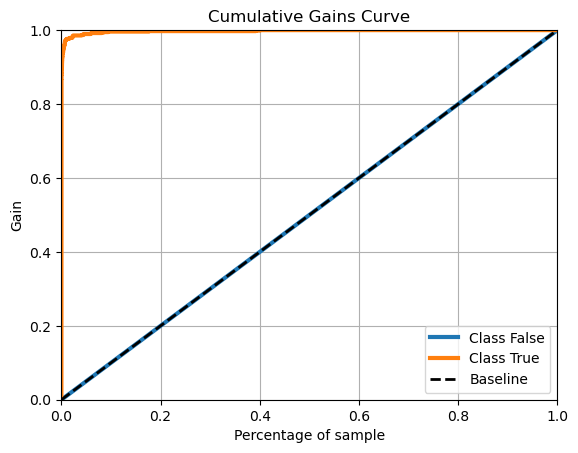

In [38]:
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(y_true=Y_c[['target']], y_probas =  probab_rf)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


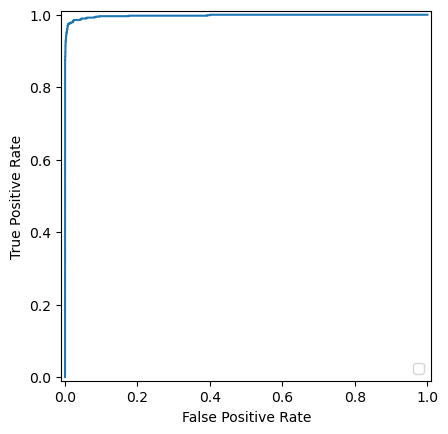

In [39]:
from sklearn.metrics import RocCurveDisplay, roc_curve

fpr, tpr, _ = roc_curve(Y_c[['target']], score_rf)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

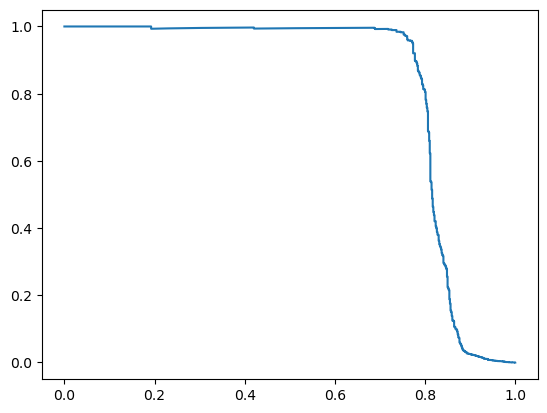

In [40]:
precision, recall, thresholds = skplt.metrics.precision_recall_curve(Y_c[['target']], score_rf)
plt.plot(recall, precision)

In [41]:
recall[recall>0.8].min() # 0.8010540184453228
precision[precision>0.8].min() #0.8002832861189801

0.8010540184453228

## Monthly analysis

In [42]:
pd.crosstab(testeo['mes'], Y_c['target'])

target,False,True
mes,,
1,1717210,118
2,1765411,58
3,2030724,44
4,2116204,87
5,2289892,69
6,2193663,101
7,2314224,50
8,2296945,68
9,2420668,75


In [43]:
#Veo cuantos falsos positivos tengo con el punto de corte
tes_corte = testeo[Y_c['pred_corte']==True]
Y_c_corte = Y_c[Y_c['pred_corte']==True]

pd.crosstab(tes_corte['mes'], Y_c_corte['target'])

target,False,True
mes,,
1,17145,118
2,19197,58
3,21815,44
4,20603,87
5,21760,69
6,21736,100
7,22631,50
8,21767,68
9,24281,65


In [44]:
Tabla_mes = pd.DataFrame(pd.concat([testeo['mes'],testeo['fraud_classification'], 
                                     Y_c['FRAUD_DECILE'], Y_c['target']],axis=1))

In [45]:
Tabla_mes[Tabla_mes['target']==True]
pd.crosstab(Tabla_mes.mes, Tabla_mes.FRAUD_DECILE)

FRAUD_DECILE,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
mes,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,17181,16852,16709,16568,16417,16509,16628,16433,16302,16591,16528,16333,16572,16627,16341,16380,16509,16269,16278,16314,16502,16209,16475,16315,16253,16323,16373,16441,16625,16096,16255,16507,16460,16475,16446,16446,16260,16333,16455,16673,16434,16320,16408,16482,16546,16522,16466,16455,16366,16569,16581,16777,16543,16819,16561,16680,16738,16889,16769,16702,16968,16698,16754,16795,16943,16817,17194,17101,17118,17102,17414,17169,17447,17469,17336,17340,17437,17757,17655,17933,18063,17969,18131,18154,17904,18437,18574,18382,18534,18764,18316,18889,18892,19107,19422,19838,20053,20568,21520,23474
2,19143,18240,17800,17942,17829,17514,17624,17516,17458,17286,17139,16993,17296,17286,17272,17122,17122,17207,17391,17159,17169,17219,17043,17052,17192,17036,17075,16965,16718,16898,16749,17025,16857,16972,17033,16671,16999,16962,16922,16967,16854,16979,16710,16854,17078,16990,16965,16822,16810,16808,16972,16857,17157,16961,17172,17195,17133,17146,17254,17100,17343,17255,17201,17418,17377,17232,17442,17485,17410,17694,17686,17650,17639,17950,18068,17906,18204,18173,18235,18335,18402,18481,18494,18548,18737,18635,18779,18656,18732,19061,19079,18862,18961,19300,19377,19285,19566,20004,20379,20748
3,21730,20900,20356,20284,19968,19773,19700,19498,19440,19676,19450,19501,19595,19273,19224,19452,19117,19120,19095,19135,19091,19150,18896,19181,19089,19030,19097,18964,18946,18897,18991,18867,18773,18799,18895,18881,18726,18857,18916,18851,18871,18625,18963,18962,18774,19054,19130,18996,18968,18956,19076,19029,19155,19100,18831,19300,19216,19067,19212,19335,19326,19343,19674,19458,19661,19785,19759,19901,19972,19996,19909,20304,20464,20315,20516,20608,20662,21060,21029,21215,21271,21524,21885,21997,22271,22303,22522,23102,22975,23293,23553,23883,24035,24391,24912,25127,25435,26158,26314,27056
4,20583,19637,19478,19073,19141,18893,19303,19228,18826,18775,18761,18783,18908,18718,18749,18998,18728,18963,18947,18797,18725,18668,18682,18708,18687,18932,18679,18816,18981,18773,18840,18881,18654,18760,18697,18872,19098,18959,18950,19259,19070,19057,19275,18876,19138,19207,19223,19324,19308,19565,19530,19663,19630,19459,19578,19730,19794,20097,20042,20291,20194,20414,20301,20654,20717,20509,20793,21117,21223,21336,21640,21500,21707,21977,22135,22274,22553,22570,23095,22871,23364,23601,23875,24108,24483,24756,24989,25063,25752,26072,26718,26982,27488,28059,28956,29055,29987,30734,31967,32935
5,21709,22184,22459,22290,22198,22002,22010,21999,22164,21847,21714,21882,21781,21659,21513,21850,21577,21621,21638,21696,21455,21508,21601,21668,21743,21332,21517,21607,21597,21476,21414,21628,21397,21400,21587,21182,21420,21405,21736,21545,21389,21723,21543,21467,21666,21504,21707,22030,21714,21653,21769,21755,21837,22061,21728,21749,21827,21939,22041,22067,22428,22392,22220,22463,22410,22436,22499,23005,22721,22706,23162,23059,23205,23284,23465,23668,23716,23746,24223,24297,24216,24496,24597,24944,24870,24999,25371,25400,25682,26097,26246,26309,26611,26764,27139,27584,28152,28301,29096,28802
6,21708,22623,23264,23166,23077,23170,22614,23005,22766,23071,22842,22696,22501,22508,22494,22192,22317,22434,22350,22129,22195,22003,22107,22168,22328,22245,21927,21837,21958,22005,21813,22001,21850,22005,21588,21768,21833,21719,21635,21662,21552,21610,21542,21240,21347,21535,21479,21480,21467,21195,21319,21402,20954,21029,21283,21225,21386,21351,21279,21282,21003,21086,21373,21247,21219,21289,21519,21399,21175,21527,21295,21481,21379,21326,21072,21367,21541,21463,21373,21265,21582,21441,21942,21566,21782,21596,21859,22207,22300,22003,22350,22545,22670,22568,22574,23218,233

In [46]:
pd.crosstab(Tabla_mes.mes[Tabla_mes['target']==True], Tabla_mes.FRAUD_DECILE[Tabla_mes['target']==True])

FRAUD_DECILE,1,2,3,5,6,7,9,10,18,40,41
mes,,,,,,,,,,,
1,118,0,0,0,0,0,0,0,0,0,0
2,58,0,0,0,0,0,0,0,0,0,0
3,44,0,0,0,0,0,0,0,0,0,0
4,87,0,0,0,0,0,0,0,0,0,0
5,69,0,0,0,0,0,0,0,0,0,0
6,100,0,0,1,0,0,0,0,0,0,0
7,50,0,0,0,0,0,0,0,0,0,0
8,68,0,0,0,0,0,0,0,0,0,0
9,65,3,2,0,0,0,2,0,1,1,1


In [47]:
Tabla_mes.loc[Tabla_mes['target']==True,['mes','fraud_classification','FRAUD_DECILE']]

,mes,fraud_classification,FRAUD_DECILE
11467,2,Distraction,1
68122,1,Distraction,1
100079,7,Real,1
130136,8,Real,1
135191,5,Real,1
...,...,...,...
24993504,12,Real,1
25037728,12,Real,1
25057844,12,Real,1
25392204,12,Real,1


# Monthly indicators

In [48]:
i = 0
summary_metrics = pd.DataFrame(columns = ['month','year', 'precision', 'recall','alerts','frauds&dist','frauds','detected'] )
for y in  testeo['year'].unique():
    for m in  testeo['mes'].unique():
        
        subset_mes = Y_c[(testeo['year']==y) & (testeo['mes']==m)]
        precision = precision_score(subset_mes[['targetF']], subset_mes['pred_corte'])
        recall = recall_score(subset_mes[['targetF']], subset_mes['pred_corte'])
        summary_metrics.loc[i,'month'] = m
        summary_metrics.loc[i,'year'] = y
        summary_metrics.loc[i,'precision'] = precision
        summary_metrics.loc[i,'recall'] = recall
        summary_metrics.loc[i,'alerts'] = subset_mes['pred_corte'].sum()
        summary_metrics.loc[i,'frauds'] = subset_mes['target'].sum()
        summary_metrics.loc[i,'frauds&dist'] = subset_mes['target'].sum()
        summary_metrics.loc[i,'frauds'] = (subset_mes['fraud_classification']=='Real').sum()
        summary_metrics.loc[i,'detected'] = ((subset_mes['pred_corte']==True) & (subset_mes['target']==True) & (subset_mes['fraud_classification']=='Real')).sum()
        #print ('Year:', y, 'Month:',m)
        #print ('Precision:', precision, 'Recall:',recall)
        i = i+1
summary_metrics.sort_values('month')

,month,year,precision,recall,alerts,frauds&dist,frauds,detected
6,1,2023,0.003707,1.0,17263,118,64,64
0,2,2023,0.001766,1.0,19255,58,34,34
5,3,2023,0.001006,1.0,21859,44,22,22
1,4,2023,0.002948,1.0,20690,87,61,61
2,5,2023,0.002061,1.0,21829,69,45,45
3,6,2023,0.00316,0.985714,21836,101,70,69
4,7,2023,0.001323,1.0,22681,50,30,30
7,8,2023,0.001695,1.0,21835,68,37,37
8,9,2023,0.00152,0.840909,24346,75,44,37
9,10,2023,0.001176,0.90625,24651,46,32,29


In [49]:
summary_metrics.sort_values('month')

,month,year,precision,recall,alerts,frauds&dist,frauds,detected
6,1,2023,0.003707,1.0,17263,118,64,64
0,2,2023,0.001766,1.0,19255,58,34,34
5,3,2023,0.001006,1.0,21859,44,22,22
1,4,2023,0.002948,1.0,20690,87,61,61
2,5,2023,0.002061,1.0,21829,69,45,45
3,6,2023,0.00316,0.985714,21836,101,70,69
4,7,2023,0.001323,1.0,22681,50,30,30
7,8,2023,0.001695,1.0,21835,68,37,37
8,9,2023,0.00152,0.840909,24346,75,44,37
9,10,2023,0.001176,0.90625,24651,46,32,29


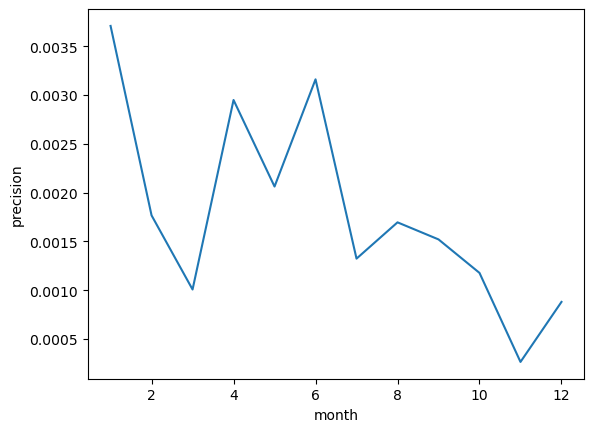

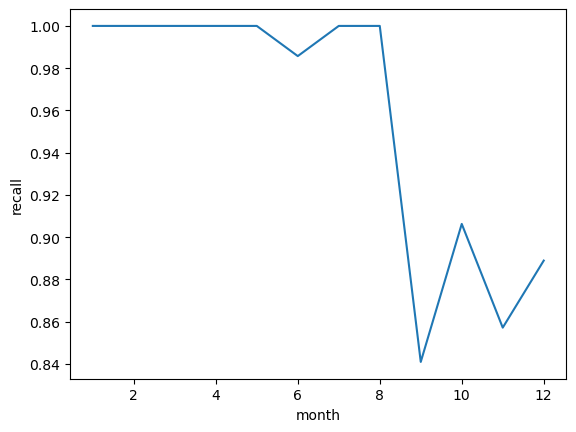

In [50]:
# Recall and precision by month
sns.lineplot(data = summary_metrics, x ='month', y = 'precision')
plt.show()
sns.lineplot(data = summary_metrics, x ='month', y= 'recall')
plt.show()

## Daily analysis

In [51]:
tes_corte_01['date_receiver'].dt.floor('d')

904        2023-07-18
3212       2023-05-25
3841       2023-07-14
5615       2023-02-05
8512       2023-08-07
              ...    
26474080   2023-12-04
26475250   2023-12-03
26477406   2023-12-26
26477891   2023-12-22
26478449   2023-12-26
Name: date_receiver, Length: 26799, dtype: datetime64[ns]

In [52]:
ALERTAS_01 = pd.crosstab(tes_corte_01['date_receiver'].dt.floor('d'), Y_c_corte_01['targetF'])
ALERTAS_01.to_csv ('./alertas.csv')

In [53]:
FRAUDES = pd.crosstab(testeo['date_receiver'].dt.floor('d'), Y_c['targetF'])
FRAUDES.to_csv ('./fraudes.csv')

In [54]:
FRAUDES

targetF,False,True
date_receiver,,
2023-01-01,15754,0
2023-01-02,58123,0
2023-01-03,48448,0
2023-01-04,44212,11
2023-01-05,43613,20
...,...,...
2023-12-27,56459,0
2023-12-28,61514,0
2023-12-29,98627,1


In [55]:
Y_c

,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6,target,preds_rf,score_rf,pred_corte,FRAUD_DECILE,fraud_classification,targetF,pred_corte_01,pred_corte_02,pred_corte_03,pred_corte_04
0,False,False,False,False,False,True,False,False,False,3.612820e-13,False,98,None,False,False,False,False,False
1,False,False,False,False,False,True,False,False,False,2.901295e-10,False,11,None,False,False,False,False,False
2,False,False,True,False,False,False,False,False,False,1.551777e-11,False,47,None,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,4.051699e-12,False,73,None,False,False,False,False,False
4,False,False,False,False,False,True,False,False,False,4.378553e-12,False,71,None,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26478906,False,False,False,False,True,False,False,False,False,9.641731e-12,False,56,None,False,False,False,False,False
26478907,False,False,False,False,False,True,False,False,False,1.210502e-12,False,90,None,False,False,False,False,False
26478908,False,False,False,False,False,True,False,False,False,1.618070e-11,False,46,None,False,False,False,False,False
26478909,True,False,False,False,False,False,False,False,False,1.119690e-08,False,2,None,False,False,False,False,False
